In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer

For text classification, tokenization can be performed using texts_to_sequences method and texts_to_matrix method. The former is used when list of indexes is required and the later is used when binary list is required similar to one hot encoding.

texts_to_sequences method is used in RNN, GRU, LSTM and its output is sent to the Embedding layer for create word embedding.

texts_to_matrix method is used in traditional ML models like logistic regression, Naive Bayes

In [89]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning IITG/Project/Twitter Sentiment Analysis/archive/twitter_training.csv',
                 header=None,
                 names = ['ID','Category','Labels','Text'])

In [92]:
df.loc[df['Labels'] == 'Irrelevant','Labels'] = 'Neutral'

In [93]:
df['Labels'].value_counts()

,count
Labels,
Neutral,31308
Negative,22542
Positive,20831


In [94]:
#Since the input to the model is Text the embedding fails when there is no text and this is induce unnecessary error
#and affects the performance of the model.Since the Nan rows account to less than 1% of the overall data,
#lets drop these rows
#total rows 74681 after dropna num rows 73995

df.dropna(subset='Text',inplace=True)

In [95]:
#function to clean the text
import re
def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#", "", text)
  text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

df['Text'] = df['Text'].apply(clean_text)
df = df[df['Text']!='']

In [96]:
#Split Labels and Inputs into separate DF's
df_y = df['Labels']
df_x = df['Text']

In [97]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(df_x)
sequences = tokenizer.texts_to_sequences(df_x)
word_index = tokenizer.word_index

In [98]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_y)
print('mapping of labels',list(label_encoder.classes_))

mapping of labels ['Negative', 'Neutral', 'Positive']


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(sequences,labels,test_size=0.2,random_state=42,stratify=labels)

In [100]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_len,padding='post')
X_val = pad_sequences(X_val, maxlen=max_len,padding='post')

In [16]:
X_train

array([[1485,  292,   36, ...,    0,    0,    0],
       [ 136,    7, 3364, ...,    0,    0,    0],
       [ 545,  692,  207, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [ 771,  250, 1672, ...,    0,    0,    0],
       [ 392,   14,  571, ...,    0,    0,    0]], dtype=int32)

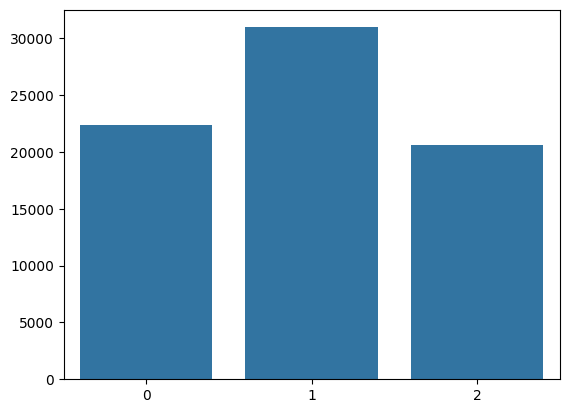

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.barplot(x=df['Labels'].value_counts().index, y=df['Labels'].value_counts().values)
sns.barplot(x=np.unique_counts(labels).values, y=np.unique_counts(labels).counts)
plt.show()

In [101]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [102]:
class_weights

{np.int64(0): np.float64(1.1029499850254567),
 np.int64(1): np.float64(0.7968733095315373),
 np.int64(2): np.float64(1.1926969476155778)}

### Simple RNN Model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
model = Sequential()
model.add(Embedding(10000,64))
model.add(SimpleRNN(64))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.3429 - loss: 1.1012 - val_accuracy: 0.4156 - val_loss: 1.0960
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4023 - loss: 1.0891 - val_accuracy: 0.3022 - val_loss: 1.1077
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3281 - loss: 1.0998 - val_accuracy: 0.4187 - val_loss: 1.0928
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3428 - loss: 1.0997 - val_accuracy: 0.3761 - val_loss: 1.0951
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3633 - loss: 1.0993 - val_accuracy: 0.4713 - val_loss: 1.0469
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4593 - loss: 1.0361 - val_accuracy: 0.5234 - val_loss: 0.9886
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5545 - loss: 0.9448 - val_accuracy: 0.5879 - val_loss: 0.9332
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5852 - loss: 0.9115 - val_acc

In [46]:
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print('Training Accuracy:', training_acc[-1:])
print('Validation Accuracy:', val_acc[-1:])

Training Accuracy: [0.754155695438385]
Validation Accuracy: [0.6554496884346008]


Lets stack Simple RNN layers to check if the performance improves

In [65]:
model=Sequential()
model.add(Embedding(10000,64))
model.add(SimpleRNN(64,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.3336 - loss: 1.1179 - val_accuracy: 0.2795 - val_loss: 1.1160
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3329 - loss: 1.1096 - val_accuracy: 0.3209 - val_loss: 1.1113
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3361 - loss: 1.1082 - val_accuracy: 0.3579 - val_loss: 1.0998
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3411 - loss: 1.0999 - val_accuracy: 0.3602 - val_loss: 1.1021
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3532 - loss: 1.0990 - val_accuracy: 0.3526 - val_loss: 1.0989
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3533 - loss: 1.0982 - val_accuracy: 0.3411 - val_loss: 1.1027
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3523 - loss: 1.0979 - val_accuracy: 0.3958 - val_loss: 1.0956
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3435 - loss: 1.1005 - 

In [68]:
training_acc_srnn = history.history['accuracy']
val_acc_srnn = history.history['val_accuracy']
print('Training Accuracy:', training_acc_srnn[-1:])
print('Validation Accuracy:', val_acc_srnn[-1:])

Training Accuracy: [0.3566626012325287]
Validation Accuracy: [0.3399553894996643]


The stacked RNN layers model is performing poorly compared to simple RNN model. This is due to vanishing gradients as the number of RNN layers increase. Now lets try with LSTM.

It is very important to be careful with the tokenization and data cleaning for empty tweets like '', as part of padding all zeros are added which the LSTM thinks as actual embeddings to learn and it badly affects the learning.

mask_zero = True, tell the Embedding layer to mask the zeros which are added as part of padding that it to ignore those values



### LSTM Model

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(10000,128,input_length=143,mask_zero=True))
model.add(LSTM(128,dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5863 - loss: 0.8786 - val_accuracy: 0.7558 - val_loss: 0.5933
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8077 - loss: 0.4650 - val_accuracy: 0.8100 - val_loss: 0.4761
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8652 - loss: 0.3322 - val_accuracy: 0.8303 - val_loss: 0.4403
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8932 - loss: 0.2613 - val_accuracy: 0.8507 - val_loss: 0.4132
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9148 - loss: 0.2115 - val_accuracy: 0.8492 - val_loss: 0.4185
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9234 - loss: 0.1855 - val_accuracy: 0.8534 - val_loss: 0.4208
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9324 - loss: 0.1637 - val_accuracy: 0.8560 - val_loss: 0.4443
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9383 - loss: 0.1486 - val_accu

In [80]:
training_acc_lstm = history.history['accuracy']
val_acc_lstm = history.history['val_accuracy']
print('Training Accuracy:', training_acc_lstm[-1:])
print('Validation Accuracy:', val_acc_lstm[-1:])

Training Accuracy: [0.9673477411270142]
Validation Accuracy: [0.879853367805481]


### GRU Model

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
model = Sequential()
model.add(Embedding(10000,128,input_length=143,mask_zero=True))
model.add(GRU(128,dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5901 - loss: 0.8655 - val_accuracy: 0.7490 - val_loss: 0.6019
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7997 - loss: 0.4826 - val_accuracy: 0.7967 - val_loss: 0.4992
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8568 - loss: 0.3577 - val_accuracy: 0.8249 - val_loss: 0.4595
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8853 - loss: 0.2829 - val_accuracy: 0.8340 - val_loss: 0.4537
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9019 - loss: 0.2447 - val_accuracy: 0.8361 - val_loss: 0.4410
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9161 - loss: 0.2090 - val_accuracy: 0.8479 - val_loss: 0.4408
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9288 - loss: 0.1737 - val_accuracy: 0.8530 - val_loss: 0.4487
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9359 - loss: 0.1585 - val_accu

### Bidirectional GRU

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional
model = Sequential()
model.add(Embedding(10000,128,input_length=143,mask_zero=True))
model.add(Bidirectional(GRU(64,dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [110]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val,y_val),
                    epochs=20,
                    batch_size=128,
                    class_weight=class_weights,
                    callbacks=[es])

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5911 - loss: 0.8543 - val_accuracy: 0.7756 - val_loss: 0.5472
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8266 - loss: 0.4245 - val_accuracy: 0.8333 - val_loss: 0.4328
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8873 - loss: 0.2826 - val_accuracy: 0.8549 - val_loss: 0.3869
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9139 - loss: 0.2128 - val_accuracy: 0.8660 - val_loss: 0.3672
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9312 - loss: 0.1724 - val_accuracy: 0.8671 - val_loss: 0.3769
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9424 - loss: 0.1458 - val_accuracy: 0.8711 - val_loss: 0.4013
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9490 - loss: 0.1263 - val_accuracy: 0.8742 - val_loss: 0.4011


### Test data predictions on Bidirectional GRU



In [129]:
df_test = pd.read_csv('/content/drive/MyDrive/Deep Learning IITG/Project/Twitter Sentiment Analysis/archive/twitter_validation.csv',
                      header=None,
                      names = ['ID','Category','Labels','Text'])

df_test.loc[df_test['Labels'] == 'Irrelevant','Labels'] = 'Neutral'

df_test.dropna(subset='Text',inplace=True)

df_test['Text'] = df_test['Text'].apply(clean_text)

df_test = df_test[df_test['Text']!='']

df_y_test = df_test['Labels']
df_x_test = df_test['Text']

X_test = tokenizer.texts_to_sequences(df_x_test)

y_test = label_encoder.transform(df_y_test)

X_test_padded = pad_sequences(X_test, maxlen=max_len,padding='post')



In [130]:
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


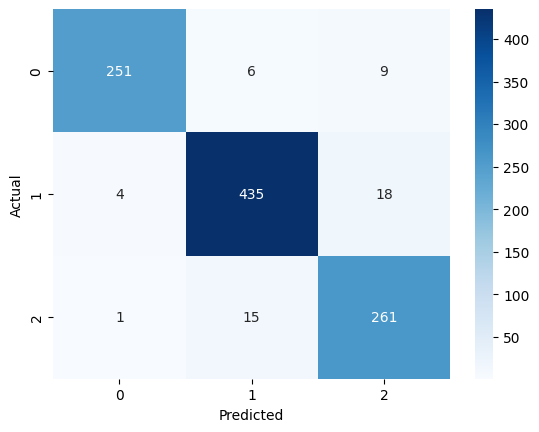

In [137]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       266
           1       0.95      0.95      0.95       457
           2       0.91      0.94      0.92       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

